Choose a datasets: 
 1 -> AMOCO_HN 
 2 -> provaADM1 
 3 -> bsm2 
 4 -> matlab 
 5 -> thoni
Data are from: amoco_HN
mu1,max: 0.3179441566590626; Ks1:  0.3934383020566712; Cd1: 0.07145038157763807
mu2,max: 0.1395227951114702; Ks2:  3.0523454127694714; KI2: 199.2865903880199; Cd2: 0.17302628019377272
k1: [18.89428158], intercept: 0.614474830334951
k2: [815.32471023], intercept: -5.079308170919209
k3: [956.2605334], intercept: -5.079308170919209
k4: [10.46146164], intercept: 0.0
k5: [191.38876052], intercept: 0.0
k6: [252.89930627], intercept: 0.7546849933824298
k_hyd: [5.00241138], intercept: -0.6685035332106093
kLa: [23.21029151],     intercept: 2.6833587136628143,

 STEADY STATE VALUES 

S.S. of XT   0.3166804680877583
S.S. of X1   1.149200718776252
S.S. of X2   0.9585206009329962
S.S. of Z    239.74788220447437
S.S. of S1   0.11666640593408327
S.S. of S2   3.5322754028707064
S.S. of C    241.59698721271675
S.S. of CO2  5.381380411113099
S.S. of Pc   0.19651111579317454
S.S. of q_M  17.

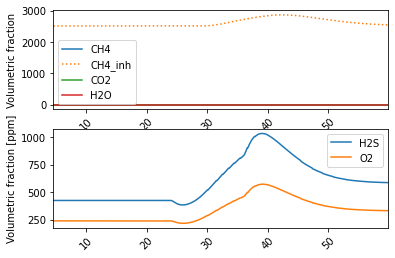

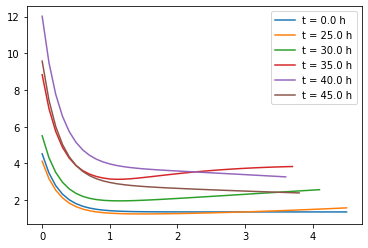

In [1]:
from main_6_4 import *
import pandas as pd


In [2]:
# Create columns in digester_out for volumetric flowrates
P_norm = 1 # [atm] Normal pressure
T_norm = 20 # [°C] Normal temperature
digester_out['Q_CH4'] = digester_out['F_CH4']*Rgas_m3_atm_K*T_norm/P_norm          # [m3/h] - Volumetric flowrate of CH4
digester_out['Q_CO2'] = digester_out['F_CO2']*Rgas_m3_atm_K*T_norm/P_norm          # [m3/h] - Volumetric flowrate of CO2
digester_out['Q_H2S'] = digester_out['F_H2S']*Rgas_m3_atm_K*T_norm/P_norm          # [m3/h] - Volumetric flowrate of H2S
digester_out['Q_H2O'] = digester_out['F_H2O']*Rgas_m3_atm_K*T_norm/P_norm          # [m3/h] - Volumetric flowrate of H2O
digester_out['Q_O2']  = digester_out['F_O2']*Rgas_m3_atm_K*T_norm/P_norm           # [m3/h] - Volumetric flowrate of O2
digester_out['Q_total'] = digester_out['Q_CH4']+digester_out['Q_CO2']+digester_out['Q_H2S']+digester_out['Q_H2O']+digester_out['Q_O2'] # [m3/h] - Total volumetric flowrate

digester_out['x_v_CH4'] = digester_out['Q_CH4']/digester_out['Q_total']          # [-] - Vol. Fraction of CH4 in the total flowrate
digester_out['x_v_CO2'] = digester_out['Q_CO2']/digester_out['Q_total']          # [-] - Vol. Fraction of CO2 in the total flowrate
digester_out['x_v_H2S'] = digester_out['Q_H2S']/digester_out['Q_total']          # [-] - Vol. Fraction of H2S in the total flowrate
digester_out['x_v_H2O'] = digester_out['Q_H2O']/digester_out['Q_total']          # [-] - Vol. Fraction of H2O in the total flowrate
digester_out['x_v_O2']  = digester_out['Q_O2']/digester_out['Q_total']           # [-] - Vol. Fraction of O2 in the total flowrate

In [ ]:
digester_out

In [ ]:
plt.plot(digester_out['t'],digester_out['x_v_H2S']*1e+6)
plt.plot(digester_out['t'],digester_out['x_v_O2']*1e+6)



Try to smooth the curve of Qin

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def proportional(Q0, PV, SP, Kp):
    MV = Q0 + Kp * (SP - PV)
    return MV

Q_0 = 10
Q = np.zeros(100)
for t in range(0,100):
    if t < 10:
        Q[t] = Q_0
    else:
        Q[t] = proportional(Q_0, Q[t-1], 2, -.8)
plt.plot(Q)

In [3]:
'Logistic adaptation of Q_in: \u03B1 = {}'.format(0.1)

'Logistic adaptation of Q_in: α = 0.1'

Text(0, 0.5, 'Q [m3/d]')

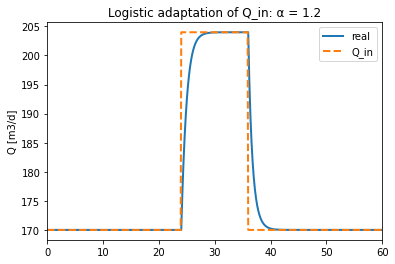

In [6]:

Q_in_real = np.ones(len(Q_in))*Q_in[0]
loc_index = 0
pippo = 0
k_logi = 1.2
for i in range(len(Q_in)):
    t=t_span[i]    
    if t < T3.index.values[0]*24:
        Q_in_real[i] = Q_in[i]
    elif t >= T3.index.values[-1]*24:
        Q_in_0_loc = Q_in_real[t_span<T3.index.values[-1]*24][-1]
        Q_in_real[i] = logistic_deviations(t, T3.Qin.iloc[-1]*Q_in[0], k_logi, T3.index.values[-1]*24, Q_in_0_loc)
    else:
        Q_in_0_loc = Q_in_real[t_span<T3.index.values[loc_index]*24][-1]
        Q_in_real[i] = logistic_deviations(t, T3.Qin.iloc[loc_index]*Q_in[0], k_logi, T3.index.values[loc_index]*24, Q_in_0_loc)
        if t >= T3.index.values[loc_index+1]*24:
            loc_index += 1
    
plt.plot(t_span,Q_in_real, label='real', linewidth=2)
plt.plot(t_span,Q_in, '--', label = 'Q_in', linewidth=2)
plt.legend()
plt.title('Logistic adaptation of Q_in: \u03B1 = {}'.format(k_logi))
plt.xlim([0,60])
plt.ylabel('Q [m3/d]')

In [ ]:
h = np.zeros(len(t_span))
h0 = h_SS
t_change = t_span[0]
index = 0
V_liq = np.zeros(len(t_span))                                 # [m3] - Liquid Volume

for i in range(len(t_span)):
    t = t_span[i]  
    if t < T3.index.values[0]*24:
        h[i] = h0
    elif t >= T3.index.values[-1]*24:
        h0_loc = h[t_span<T3.index.values[-1]*24][-1]
        t_change = T3.index.values[-1]*24
        h[i] = level_t(t, D, Q_in_real[i], SR, h0_loc, t_change)     
    else:    
        h0_loc = h[t_span<T3.index.values[index]*24][-1]
        t_change = T3.index.values[index]*24
        h[i] = level_t(t, D, Q_in_real[i], SR, h0_loc, t_change)    
        if t >= T3.index.values[index+1]*24:
            index += 1             
   
    V_liq[i] = np.pi*Dr**2*h[i]/4                             # [m3] - Liquid Volum
    if h[i] > hmax:
        print('!!! Level is too high !!!')
        input('Press Enter to continue')
    elif h[i] < hmin:
        print('!!! Level is too low !!!')
        input('Press Enter to continue')
plt.figure(figsize=(15,5))
plt.plot(t_span, h)

In [ ]:
Q_in_new = np.zeros(len(Q_in))
loc_index = 0
for i in range(len(Q_in)):
    t=t_span[i]
    if t < T3.index.values[loc_index]*24:
        Q_in_new[i] = Q_in[i]
    else:
        Q_in_new[i] = logistic_deviations(t, T3.Qin.iloc[loc_index]*Q_in[0], 0.9, T3.index.values[loc_index]*24, Q_in[loc_index])
    
plt.plot(t_span,Q_in_new)

In [ ]:
plt.plot(V_gas/(water_percentage*Q_in_new*rho_W/18*1000/24))

Inhibitions

In [ ]:
n_o2 = digester_out['O2']
x_o2 = n_o2/(digester_out['CH4']+digester_out['CO2']+digester_out['H2S']+digester_out['O2']+digester_out['H2O']) #[-]
C_o2 =  x_o2* 1/Rgas_L_atm_K/(T+273.15) # [mol/L]
w_O2 = C_o2*0.032 # [mg/L]
I_O2 = 1/(1+w_O2/3.29)
Ch4_inh = digester_out['CH4']*I_O2

In [ ]:
digester_out.loc[digester_out['t_in']>24]
